In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, make_scorer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost

import torch
import beacon

/afs/cern.ch/user/y/yuanye/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.6.9' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/cvmfs/sft.cern.ch/lcg/releases/LCG_102b/scipy/1.8.0/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/cvmfs/sft.cern.ch/lcg/releases/LCG_102b/torchvision/0.12.0/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /cvmfs/sft.cern.ch/lcg/releases/torchvision/0.12.0-2ee13/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warn(f"Failed to load image Python 

-----------
Data Loading and Visualisation
---------

In [3]:
KMU2GIB_EVENT_COUNT = 20000
KMU2GSDINT_RATIO = 0.0419
K2PI_RATIO = 33.3387
KMU3_RATIO = 5.4048

In [4]:
matplotlib.rcParams['figure.figsize'] = (9, 6)
# plt.style.use('dark_background')

In [5]:
def read_dir(directory):
    # Initialize an empty list to store the dataframes
    dfs = []

    # Iterate over all files in the directory
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            # Read the CSV file into a dataframe
            filepath = os.path.join(directory, filename)
            try:
                df = pd.read_csv(filepath)
            except:
                print(f'Error reading {filepath}')
                continue
            
            # Append the dataframe to the list
            dfs.append(df)

    # Concatenate all dataframes into one
    combined_df = pd.concat(dfs, ignore_index=True)
    return combined_df

In [6]:
kmu2gib_df = read_dir("/eos/user/y/yuanye/Analysis/data/old/kmu2gibdata")
kmu2gsd_df = read_dir("/eos/user/y/yuanye/Analysis/data/old/kmu2gsddata")
kmu2gintm_df = read_dir("/eos/user/y/yuanye/Analysis/data/old/kmu2gintmdata")
k2pi_df = read_dir("/eos/user/y/yuanye/Analysis/data/old/k2pidata")
kmu3_df = read_dir("/eos/user/y/yuanye/Analysis/data/old/kmu3data")

In [7]:
k2pi_df['CumulativeEventCount'] = k2pi_df['EventCount'].cumsum()
kmu3_df['CumulativeEventCount'] = kmu3_df['EventCount'].cumsum()
kmu2gsd_df['CumulativeEventCount'] = kmu2gsd_df['EventCount'].cumsum()
kmu2gintm_df['CumulativeEventCount'] = kmu2gintm_df['EventCount'].cumsum()
kmu2gib_df['CumulativeEventCount'] = kmu2gib_df['EventCount'].cumsum()

In [8]:
kmu2gsd_df_sub = kmu2gsd_df[kmu2gsd_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * (KMU2GSDINT_RATIO/2)]
kmu2gintm_df_sub = kmu2gintm_df[kmu2gintm_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * (KMU2GSDINT_RATIO/2)]
kmu2gsdintm_df_sub = pd.concat([kmu2gsd_df_sub, kmu2gintm_df_sub], ignore_index=True)
k2pi_df_sub = k2pi_df[k2pi_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * K2PI_RATIO]
kmu3_df_sub = kmu3_df[kmu3_df["CumulativeEventCount"] < KMU2GIB_EVENT_COUNT * KMU3_RATIO]

---------
Exploratory Analysis
---------

In [9]:
# calculate the acceptance ratio
kmu2gib_acceptance = len(kmu2gib_df) / KMU2GIB_EVENT_COUNT
kmu2gsd_acceptance = len(kmu2gsd_df) / kmu2gsd_df["CumulativeEventCount"].max()
kmu2gintm_acceptance = len(kmu2gintm_df) / kmu2gintm_df["CumulativeEventCount"].max()
k2pi_acceptance = len(k2pi_df) / k2pi_df["CumulativeEventCount"].max()
kmu3_acceptance = len(kmu3_df) / kmu3_df["CumulativeEventCount"].max()

print("kmu2gib Acceptance: ", kmu2gib_acceptance)
print("kmu2gsd- Acceptance: ", kmu2gsd_acceptance)
print("kmu2gint- Acceptance: ", kmu2gintm_acceptance)
print("k2pi Acceptance: ", k2pi_acceptance)
print("kmu3 Acceptance: ", kmu3_acceptance)

kmu2gib Acceptance:  0.22355
kmu2gsd- Acceptance:  0.20536429143314652
kmu2gint- Acceptance:  0.20920690517888416
k2pi Acceptance:  0.03327978302198581
kmu3 Acceptance:  0.030396445324986105


In [10]:
# Add mode column for classification
# 0: kmu2gib, 1: kmu2gsd, 2: kmu2gintm, 3: k2pi, 4: kmu3
kmu2gib_df["Mode"] = 0
kmu2gsdintm_df_sub["Mode"] = 1
k2pi_df_sub["Mode"] = 2
kmu3_df_sub["Mode"] = 3

kmu2gib_df["Signal"] = 1
kmu2gsdintm_df_sub["Signal"] = 1
k2pi_df_sub["Signal"] = 0
kmu3_df_sub["Signal"] = 0

combined_df = pd.concat([kmu2gib_df, kmu2gsdintm_df_sub, k2pi_df_sub, kmu3_df_sub], ignore_index=True)

/tmp/yuanye/ipykernel_3601383/1521287353.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  k2pi_df_sub["Mode"] = 2
/tmp/yuanye/ipykernel_3601383/1521287353.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kmu3_df_sub["Mode"] = 3
/tmp/yuanye/ipykernel_3601383/1521287353.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

In [11]:
combined_df.insert(0, "GTKMomentum", np.sqrt(combined_df["GTKMomentumX"]**2 + combined_df["GTKMomentumY"]**2 + combined_df["GTKMomentumZ"]**2))
combined_df.insert(5, "MuonMomentumPrime", np.sqrt(combined_df["MuonMomentumPrimeX"]**2 + combined_df["MuonMomentumPrimeY"]**2 + combined_df["MuonMomentumPrimeZ"]**2))
combined_df.insert(10, "MissingMomentum", np.sqrt(combined_df["MissingMomentumX"]**2 + combined_df["MissingMomentumY"]**2 + combined_df["MissingMomentumZ"]**2))

In [12]:
# Remove unnecessary columns for classification
combined_df = combined_df.drop(columns=["NLKrCells", "NLKrClusters", "NVertices", "NTracks", "GTKMomentumX", "GTKMomentumY", "GTKMomentumZ", "GTKEnergy", "GTKGamma", "GTKBeta", "EventCount", "GTKMomentumX", "GTKMomentumY", "GTKMomentumZ", "MuonMomentumX", "MuonMomentumY", "MuonMomentumZ", "MuonMomentumPrimeX", "MuonMomentumPrimeY", "MuonMomentumPrimeZ", "MissingMomentumX", "MissingMomentumY", "MissingMomentumZ", "CDAAfterCut", "CumulativeEventCount", "CDA", "TrackTime", "QChi2Track"])

Signal to Background Ratio Analysis
-----------------------------------

In [13]:
resolution = 100
radius = 0.05

x_start = 0.3
x_end = 1.1
y_start = -0.1
y_end = 1.1

In [14]:
significance = []

for y in np.linspace(y_start + radius, y_end - radius, resolution):
    temp_significance = []
    for x in np.linspace(x_start + radius, x_end - radius, resolution):
        temp_df = combined_df[((y - combined_df["XGamma"]) ** 2 + (x - combined_df["XMu"]) ** 2) < radius ** 2]
        num_signal = len(temp_df[temp_df["Signal"] == 1])
        num_background = len(temp_df[temp_df["Signal"] == 0])
        if num_signal + num_background == 0:
            temp_significance.append(np.NaN)
        else:
            temp_significance.append(num_signal / np.sqrt(num_signal + num_background))
    
    significance.append(temp_significance)

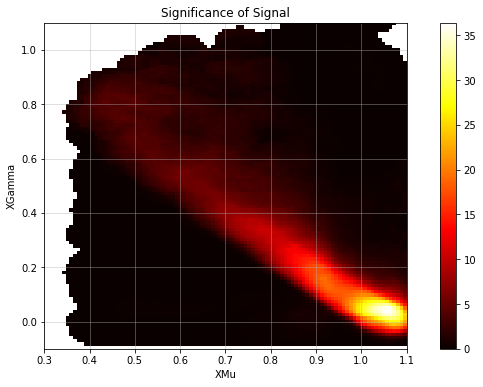

In [15]:
plt.figure(figsize=(12, 6))
plt.imshow(np.array(significance), cmap='hot', origin="lower", extent=[x_start, x_end, y_start, y_end], aspect=0.6)
plt.grid(alpha=0.5)
plt.title("Significance of Signal")
plt.xlabel("XMu")
plt.ylabel("XGamma")
plt.colorbar()

In [16]:
significance_1D = []
for i in range(len(significance)):
    significance_1D.extend(significance[i])

In [17]:
# calculate the signal significance for each event in the dataframe
for index, row in combined_df.iterrows():
    temp_df = combined_df[((row["XGamma"] - combined_df["XGamma"]) ** 2 + (row["XMu"] - combined_df["XMu"]) ** 2) < radius ** 2]
    num_signal = len(temp_df[temp_df["Signal"] == 1])
    num_background = len(temp_df[temp_df["Signal"] == 0])
    combined_df.at[index, "Significance"] = num_signal / np.sqrt(num_signal + num_background)

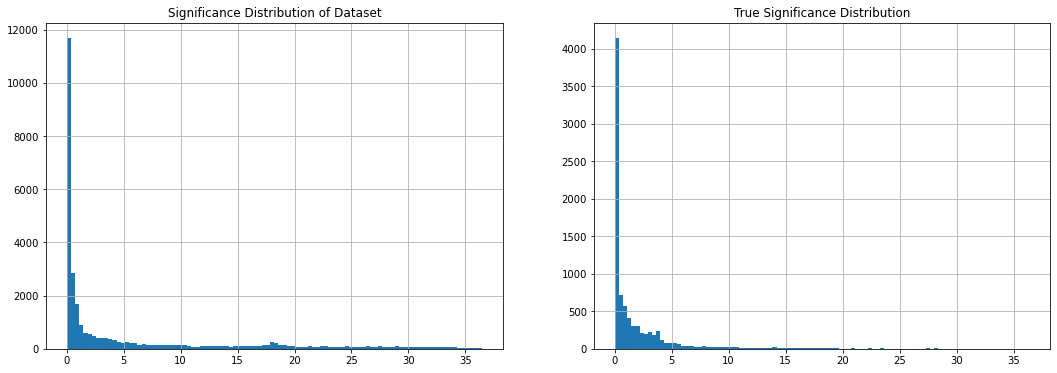

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].hist(combined_df["Significance"], bins=100)
ax[0].set_title("Significance Distribution of Dataset")
ax[0].grid()
ax[1].hist(significance_1D, bins=100)
ax[1].set_title("True Significance Distribution")
ax[1].grid()

In [19]:
# combined_significant_df_sup = combined_df[combined_df["Significance"] < 10]
# combined_significant_df = combined_significant_df_sup[combined_significant_df_sup["Significance"] > 1]

combined_significant_df = combined_df[combined_df["Significance"] > 7]

----------
Machine Learning
----------

In [20]:
X = combined_significant_df.drop(columns=["Mode", "Signal"])
y = combined_significant_df["Signal"]

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Decision Tree
-------------

In [22]:
# Decision Tree
dtree = DecisionTreeClassifier()
dtree.fit(X_train, y_train)

DecisionTreeClassifier()

In [23]:
y_pred_tree = dtree.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred_tree)))

Accuracy: 0.9666522304027718


In [24]:
report = classification_report(y_test, y_pred_tree, target_names=["Background", "Signal"])
print(report)

              precision    recall  f1-score   support

  Background       0.96      0.97      0.97      1205
      Signal       0.97      0.96      0.96      1104

    accuracy                           0.97      2309
   macro avg       0.97      0.97      0.97      2309
weighted avg       0.97      0.97      0.97      2309



([<matplotlib.axis.YTick at 0x7f17a62d4be0>,
 [Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')])

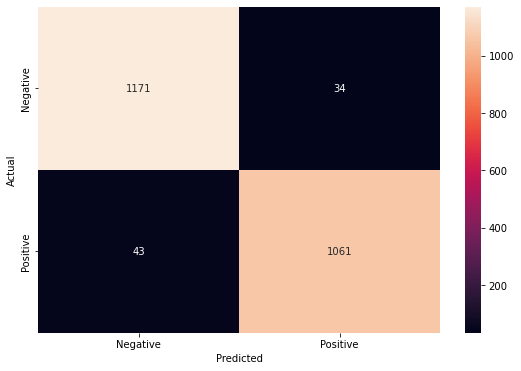

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred_tree)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])

Random Forest
----------

In [26]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)

RandomForestClassifier()

In [27]:
y_pred_forest = forest.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred_forest)))

Accuracy: 0.9809441316587267


In [28]:
print(classification_report(y_test, y_pred_forest, target_names=["Background", "Signal"]))

              precision    recall  f1-score   support

  Background       0.98      0.98      0.98      1205
      Signal       0.98      0.98      0.98      1104

    accuracy                           0.98      2309
   macro avg       0.98      0.98      0.98      2309
weighted avg       0.98      0.98      0.98      2309



([<matplotlib.axis.YTick at 0x7f17a628b3d0>,
 [Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')])

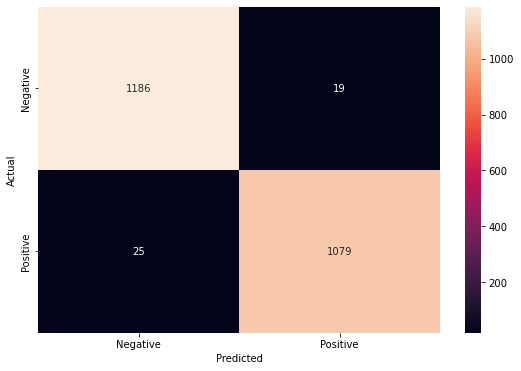

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred_forest)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])

Gradient Boosted Decision Trees
-------------------------------

In [30]:
boosted_tree = GradientBoostingClassifier(n_estimators=100)
boosted_tree.fit(X_train, y_train)

GradientBoostingClassifier()

In [31]:
y_pred_boosted_tree = boosted_tree.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred_boosted_tree)))

Accuracy: 0.9822433954092681


In [32]:
print(classification_report(y_test, y_pred_boosted_tree, target_names=["Background", "Signal"]))

              precision    recall  f1-score   support

  Background       0.98      0.99      0.98      1205
      Signal       0.98      0.98      0.98      1104

    accuracy                           0.98      2309
   macro avg       0.98      0.98      0.98      2309
weighted avg       0.98      0.98      0.98      2309



([<matplotlib.axis.YTick at 0x7f17a61317c0>,
 [Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')])

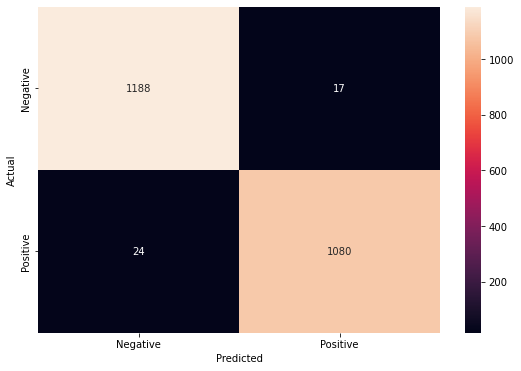

In [33]:
conf_matrix = confusion_matrix(y_test, y_pred_boosted_tree)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])

Adaptive Gradient Boosting
--------------------------

In [34]:
ada = AdaBoostClassifier(n_estimators=100)
ada.fit(X_train, y_train)

AdaBoostClassifier(n_estimators=100)

In [35]:
y_pred_ada = ada.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred_ada)))

Accuracy: 0.9753139887397142


In [36]:
print(classification_report(y_test, y_pred_ada, target_names=["Background", "Signal"]))

              precision    recall  f1-score   support

  Background       0.98      0.97      0.98      1205
      Signal       0.97      0.98      0.97      1104

    accuracy                           0.98      2309
   macro avg       0.98      0.98      0.98      2309
weighted avg       0.98      0.98      0.98      2309



([<matplotlib.axis.YTick at 0x7f17a6056cd0>,
 [Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')])

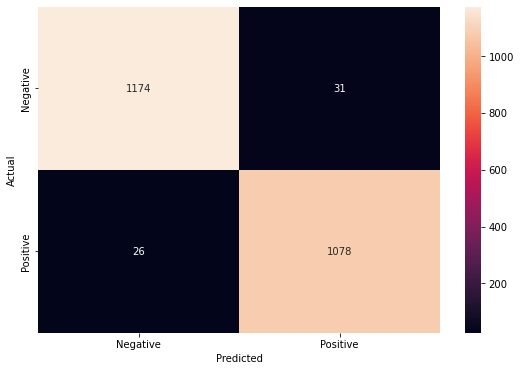

In [37]:
conf_matrix = confusion_matrix(y_test, y_pred_ada)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])

Extreme Gradient Boosting
-------------------------

Best Hyperparameters: {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.5}

In [38]:
xgb = xgboost.XGBClassifier(n_estimators=1000)
xgb.fit(X_train, y_train)

/cvmfs/sft.cern.ch/lcg/releases/LCG_102b/xgboost/0.90/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/xgboost/core.py:248: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


XGBClassifier(n_estimators=1000)

In [39]:
y_pred_xgb = xgb.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred_xgb)))

Accuracy: 0.9848419229103508


/cvmfs/sft.cern.ch/lcg/releases/LCG_102b/xgboost/0.90/x86_64-centos9-gcc11-opt/lib/python3.9/site-packages/xgboost/core.py:248: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  feature_names = data.columns.format()


In [40]:
print(classification_report(y_test, y_pred_xgb, target_names=["Background", "Signal"], digits=3))

              precision    recall  f1-score   support

  Background      0.985     0.986     0.985      1205
      Signal      0.985     0.984     0.984      1104

    accuracy                          0.985      2309
   macro avg      0.985     0.985     0.985      2309
weighted avg      0.985     0.985     0.985      2309



([<matplotlib.axis.YTick at 0x7f17a32f4160>,
 [Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')])

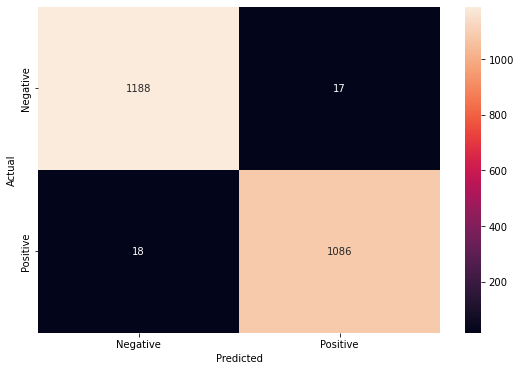

In [41]:
conf_matrix = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])

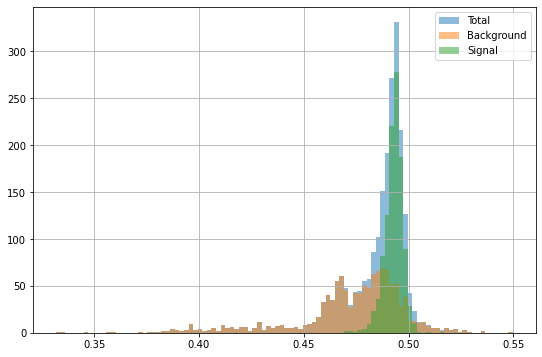

In [42]:
y_pred_xgb_df = X_test.copy()
y_pred_xgb_df["Signal_Pred"] = y_pred_xgb

bin_edges = np.histogram_bin_edges(y_pred_xgb_df["KaonMass"], bins=100)

plt.hist(y_pred_xgb_df["KaonMass"], bins=bin_edges, alpha=0.5, label="Total")
plt.hist(y_pred_xgb_df[y_pred_xgb_df["Signal_Pred"] == 0]["KaonMass"], bins=bin_edges, alpha=0.5, label="Background")
plt.hist(y_pred_xgb_df[y_pred_xgb_df["Signal_Pred"] == 1]["KaonMass"], bins=bin_edges, alpha=0.5, label="Signal")
plt.grid()
plt.legend()

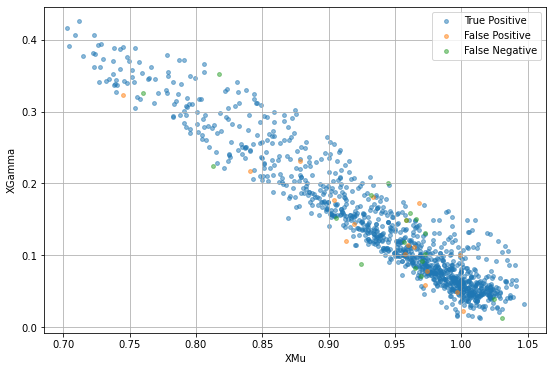

In [43]:
false_positive = X_test[(y_test == 0) & (y_pred_xgb == 1)]
false_negative = X_test[(y_test == 1) & (y_pred_xgb == 0)]
true_positive = X_test[(y_test == 1) & (y_pred_xgb == 1)]
true_negative = X_test[(y_test == 0) & (y_pred_xgb == 0)]

plt.scatter(true_positive["XMu"], true_positive["XGamma"], label="True Positive", s=15, alpha=0.5)
plt.scatter(false_positive["XMu"], false_positive["XGamma"], label="False Positive", s=15, alpha=0.5)
plt.scatter(false_negative["XMu"], false_negative["XGamma"], label="False Negative", s=15, alpha=0.5)
plt.legend()
plt.xlabel("XMu")
plt.ylabel("XGamma")
plt.grid()

In [44]:
false_positive["Signal"] = 0
false_positive["Signal_Pred"] = 1
false_negative["Signal"] = 1
false_negative["Signal_Pred"] = 0
true_positive["Signal"] = 1
true_positive["Signal_Pred"] = 1
combined_pred_df = pd.concat([true_positive, false_positive, false_negative], ignore_index=True)

/tmp/yuanye/ipykernel_3601383/3182672537.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positive["Signal"] = 0
/tmp/yuanye/ipykernel_3601383/3182672537.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  false_positive["Signal_Pred"] = 1
/tmp/yuanye/ipykernel_3601383/3182672537.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

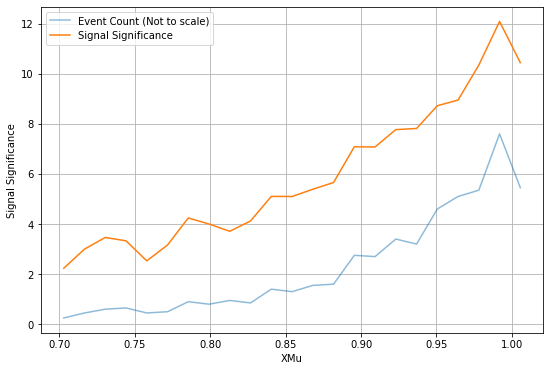

In [45]:
# plot the signal significance for each bin of XMu
bin_edges = np.histogram_bin_edges(combined_pred_df["XMu"], bins=25)[:-2]

signal_significance = []
signal_count = []

for i in range(len(bin_edges) - 1):
    temp_df = combined_pred_df[(combined_pred_df["XMu"] >= bin_edges[i]) & (combined_pred_df["XMu"] < bin_edges[i + 1])]
    num_signal = len(temp_df[temp_df["Signal_Pred"] == 1 & (temp_df["Signal"] == 1)])
    num_background = len(temp_df[temp_df["Signal_Pred"] == 0 & (temp_df["Signal"] == 1)]) + len(temp_df[temp_df["Signal_Pred"] == 1 & (temp_df["Signal"] == 0)])
    signal_count.append(len(temp_df) / 20)
    if num_signal + num_background == 0:
        signal_significance.append(np.NaN)
    else:
        signal_significance.append(num_signal / np.sqrt(num_signal + num_background))
        

plt.plot(bin_edges[:-1], signal_count, alpha=0.5, label="Event Count (Not to scale)")
plt.plot(bin_edges[:-1], signal_significance, label="Signal Significance")
plt.xlabel("XMu")
plt.ylabel("Signal Significance")
plt.grid()
plt.legend()

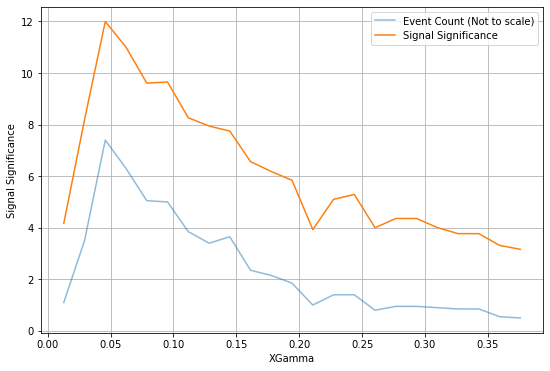

In [46]:
# plot the signal significance for each bin of XMu
bin_edges = np.histogram_bin_edges(combined_pred_df["XGamma"], bins=25)[:-2]

signal_significance = []
signal_count = []

for i in range(len(bin_edges) - 1):
    temp_df = combined_pred_df[(combined_pred_df["XGamma"] >= bin_edges[i]) & (combined_pred_df["XGamma"] < bin_edges[i + 1])]
    num_signal = len(temp_df[temp_df["Signal_Pred"] == 1 & (temp_df["Signal"] == 1)])
    num_background = len(temp_df[temp_df["Signal_Pred"] == 0 & (temp_df["Signal"] == 1)]) + len(temp_df[temp_df["Signal_Pred"] == 1 & (temp_df["Signal"] == 0)])
    signal_count.append(len(temp_df) / 20)
    if num_signal + num_background == 0:
        signal_significance.append(np.NaN)
    else:
        signal_significance.append(num_signal / np.sqrt(num_signal + num_background))
        

plt.plot(bin_edges[:-1], signal_count, alpha=0.5, label="Event Count (Not to scale)")
plt.plot(bin_edges[:-1], signal_significance, label="Signal Significance")
plt.xlabel("XGamma")
plt.ylabel("Signal Significance")
plt.grid()
plt.legend()

Deep Neural Networks
--------------------

In [47]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.int64)

In [48]:
X_train_tensor.shape, y_train_tensor.shape

(torch.Size([5386, 18]), torch.Size([5386]))

In [49]:
class DNN(beacon.Module):
    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, 16)
        self.fc4 = torch.nn.Linear(16, out_features)
        self.dropout = torch.nn.Dropout(0.25)
        self.softmax = torch.nn.Softmax(dim=1)
        self.ReLU = torch.nn.ReLU()
        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))
        x = self.fc4(x)
        x = self.softmax(x)
        return x

In [50]:
dnn = DNN(X_train_tensor.shape[1], 2)
dnn.compile(optimiser=torch.optim.Adam, learning_rate=0.03, device="cuda")

In [51]:
losses = dnn.fit_tensor(X_train_tensor, y_train_tensor, epochs=4000)

  0%|          | 0/4000 [00:00<?, ?it/s]

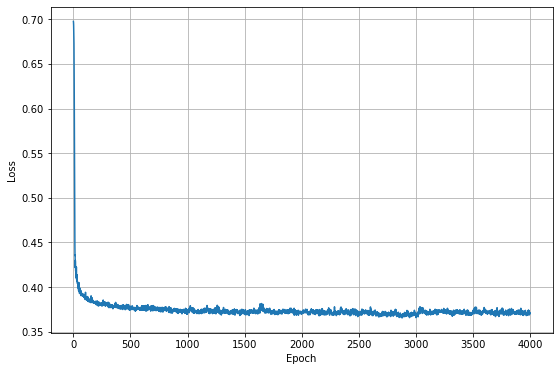

In [52]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()

In [53]:
y_pred_dnn = dnn.predict(torch.tensor(X_test.values, dtype=torch.float32))
y_pred_dnn = y_pred_dnn.argmax(dim=1).cpu().numpy()
y_pred_dnn

array([0, 1, 0, ..., 0, 0, 0])

In [54]:
accuracy_score(y_test, y_pred_dnn)

0.9475963620614984

In [55]:
print(classification_report(y_test, y_pred_dnn))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1205
           1       0.93      0.97      0.95      1104

    accuracy                           0.95      2309
   macro avg       0.95      0.95      0.95      2309
weighted avg       0.95      0.95      0.95      2309



([<matplotlib.axis.YTick at 0x7f179ce2b100>,
 [Text(0, 0.5, 'Negative'), Text(0, 1.5, 'Positive')])

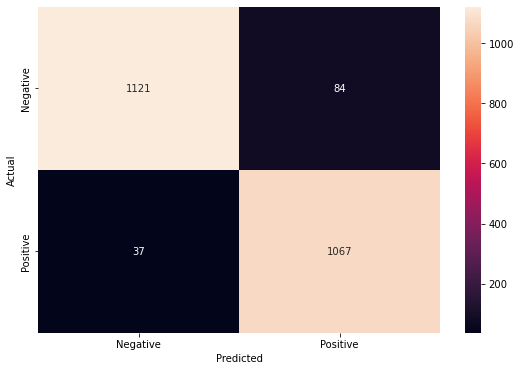

In [56]:
conf_matrix = confusion_matrix(y_test, y_pred_dnn)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Negative', 'Positive'])
plt.yticks([0.5, 1.5], ['Negative', 'Positive'])